# IR cropped h5 file exploration 


This notebook aims to demonstrate the use of the h5 file containing the cropped IR videos of the NTU-RGB-D dataset. 

By cropped, we mean that a bounding box is provided around the subject(s) using the 2D skeleton data. 

In [2]:
%matplotlib notebook
import numpy as np
import h5py
import random
import os
import sys
import time

from matplotlib import animation
import matplotlib.pyplot as plt
# Moves back one folder to use module from src folder
sys.path.insert(0, os.getcwd() + '/../')

from play_skeleton import *
from src.utils.joints import *

# Global variables (change depending on your setup)
project_dir = os.getcwd() + '/../'
h5_dataset_path = project_dir + "/data/processed/"

ir_dataset_file_name = "ir_cropped.h5"
log_file_name = "samples_names.txt"

## 1. Extract random

On our machine, it takes about 0.06s to fetch and decompress a given sample

In [3]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + log_file_name)]

# Shuffle samples_names_list 
random.shuffle(samples_names_list)

# Take first random sample
sample_name = samples_names_list[0]
sample_name = "S001C002P003R001A052"

# Open dataset
ir_dataset = h5py.File(h5_dataset_path + ir_dataset_file_name, 'r')

# Get ir video shape (n_frames, 424, 512) 
start = time.time()
ir_sample = ir_dataset[sample_name]["ir"][:]
stop = time.time()

print("It took : " + str(stop - start) + "s to fetch and decompress ir video")
print("Video size " + str(ir_sample[0].nbytes * 1e-6) + "MB")

It took : 0.10396909713745117s to fetch and decompress ir video
Video size 0.063222MB


## 2. Playback video

<IPython.core.display.Javascript object>


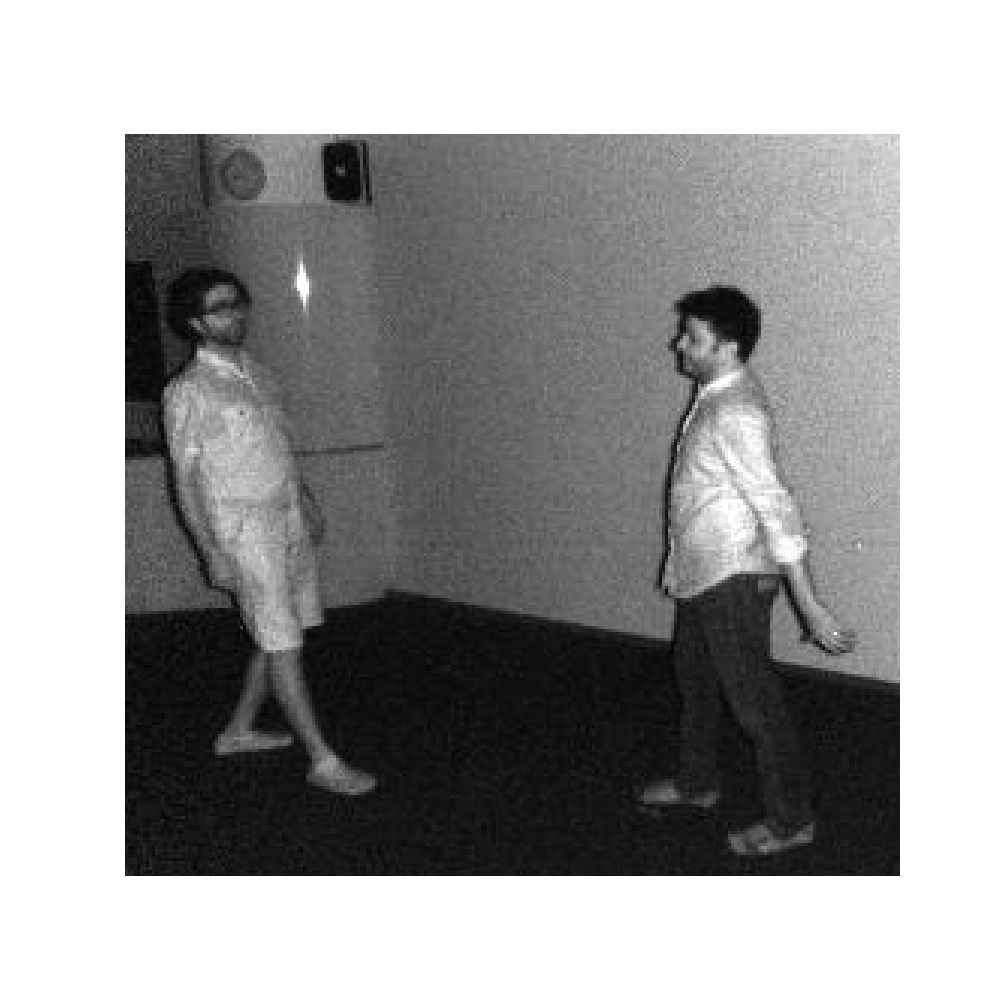

In [6]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

image = plt.imshow(ir_sample[0], interpolation='None', animated = True, cmap="gray")

plt.axis('off')

def videoAnimation(frame_index):
    image.set_data(ir_sample[frame_index])
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 1000 / 33, frames = ir_sample.shape[0], repeat = False)


# Set up formatting for the movie files
'''
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

ani.save('cropped_ir.mp4', writer=writer)
'''

## Data augmentation

<IPython.core.display.Javascript object>


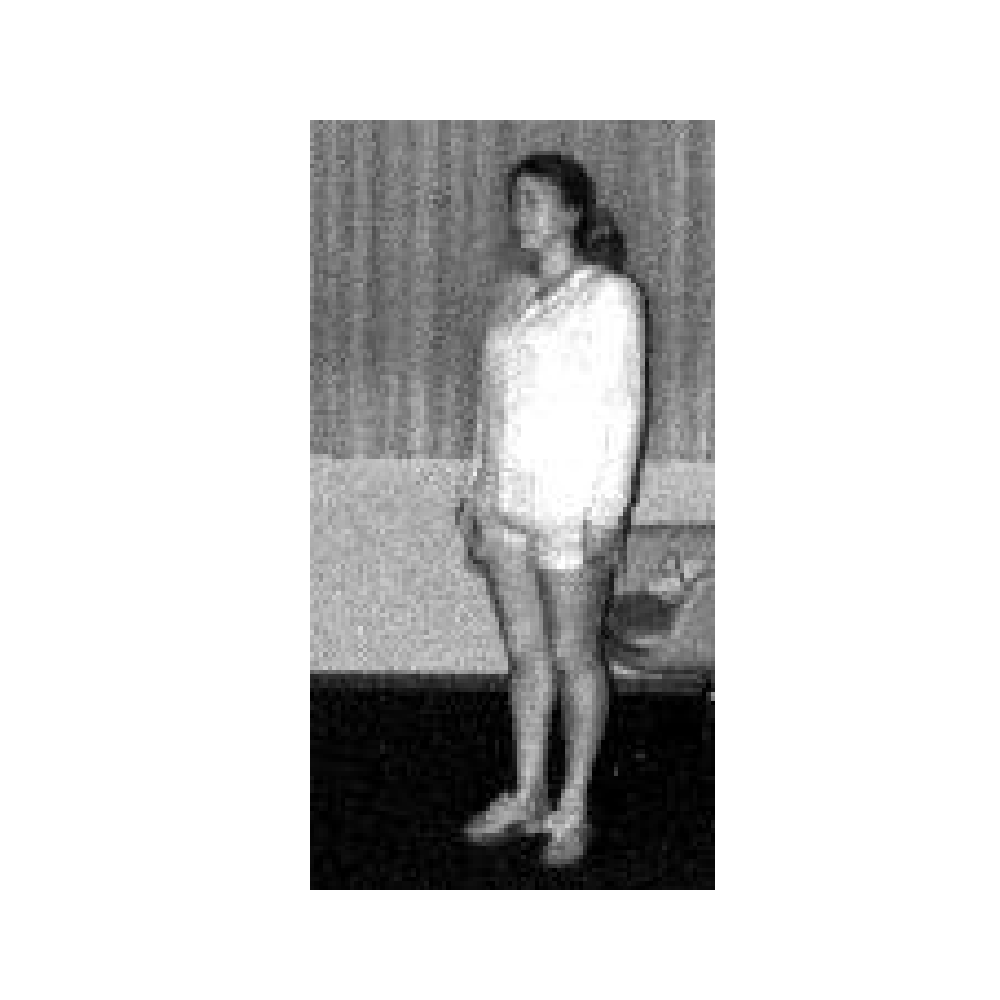

In [4]:
f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

# Horizontal flip
ir_sample = np.flip(ir_sample, axis = 2)

image = plt.imshow(ir_sample[0], interpolation='None', animated = True, cmap="gray")

plt.axis('off')


def videoAnimation(frame_index):
    image.set_data(ir_sample[frame_index])
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 1000 / 33, frames = ir_sample.shape[0], repeat = False)

## Image enhancement 

<IPython.core.display.Javascript object>


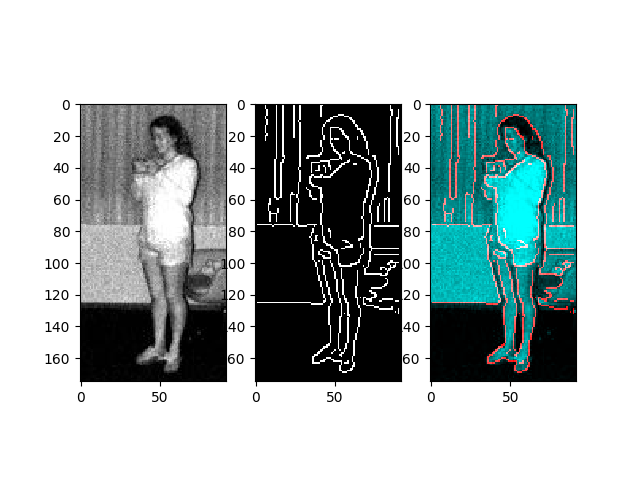

In [5]:
from matplotlib.patches import Circle
from src.utils.joints import *
from skimage import feature
from scipy import ndimage as ndi
from skimage import exposure

first_frame = ir_sample[0] / 255
first_frame_trans = ndi.gaussian_filter(first_frame, 3)
first_frame_trans = feature.canny(first_frame, sigma = 1.5)

f, (axs) = plt.subplots(1, 3)
original = axs[0].imshow(first_frame, cmap="gray")
transformed = axs[1].imshow(first_frame_trans, cmap="gray")
addition = axs[2].imshow(np.stack([first_frame, first_frame_trans, first_frame_trans], axis = 2))

num_frames = ir_sample.shape[0]

def videoAnimation(frame_index):
    frame = ir_sample[frame_index] / 255
    frame_trans = exposure.equalize_hist(frame)
    frame_trans = ndi.gaussian_filter(frame, 3)
    frame_trans = feature.canny(frame, sigma = 1.5)
    
    original.set_data(frame)
    transformed.set_data(frame_trans)
    addition.set_data(np.stack([frame_trans, frame, frame], axis = 2))
    
    return image,

ani = animation.FuncAnimation(f, videoAnimation, interval = 1000 / 33, frames = num_frames, repeat = False)